In [17]:
import os

import scipy.io as sio
import numpy as np
import torch
import torchvision
import h5py
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import patches,  lines


%matplotlib inline

In [2]:
# Source: https://stackoverflow.com/questions/41176258/h5py-access-data-in-datasets-in-svhn

def get_box_data(index, hdf5_data):
    """
    get `left, top, width, height` of each picture
    :param index:
    :param hdf5_data:
    :return:
    """
    meta_data = dict()
    meta_data['height'] = []
    meta_data['label'] = []
    meta_data['left'] = []
    meta_data['top'] = []
    meta_data['width'] = []

    def print_attrs(name, obj):
        vals = []
        if obj.shape[0] == 1:
            vals.append(obj[0][0])
        else:
            for k in range(obj.shape[0]):
                vals.append(int(hdf5_data[obj[k][0]][0][0]))
        meta_data[name] = vals

    box = hdf5_data['/digitStruct/bbox'][index]
    hdf5_data[box[0]].visititems(print_attrs)
    return meta_data

def get_name(index, hdf5_data):
    name = hdf5_data['/digitStruct/name']
    return ''.join([chr(v[0]) for v in hdf5_data[name[index][0]].value])


def aggregate_data(index, hdf5_data):
    
    image_id = get_name(index, mat_data)
    labels = get_box_data(index, mat_data)
    
    # Convert label 10 to label 0 for digit 0
    if 10 in labels['label']:
        labels['label'] = [0 if x==10 else x for x in labels['label']]
        
    metadata = {}
    
    metadata['filename'] = image_id
    metadata['metadata'] = labels

    return metadata




In [3]:
# Download SVHN data in to /data/SVHN/
# Parse all metadata from digitStruct.mat into metadata dict (long!)

file1 = 'data/SVHN/train/digitStruct.mat'
mat_data = h5py.File(file1)
size = mat_data['/digitStruct/name'].size


metadata = {}
for index in range(size):
    
    metadata[index] = aggregate_data(index, mat_data)

    if index % 1000 == 0 and index != 0:
        break

Create custom dataloader.

https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel

In [5]:
from torch.utils import data

class SVHNDataset(data.Dataset):
    
    def __init__(self, metadata, root_dir, transform=None):
        """
        Args:
            labels (dict): Dictionary containing all labels and metadata
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.metadata = metadata
        self.root_dir = root_dir
        self.transform = transform
        
        
    def __len__(self):
        return len(self.metadata)

    
    def __getitem__(self, index):
        '''
        Parameters
        ----------
        index : int
            The index of the dataset

        Returns
        -------
        X : PIL objet
        
        y : dict
            The metadata associated to the image in dict form.

        '''
        'Generates one sample of data'

        img_name = os.path.join(self.root_dir,
                                self.metadata[index]['filename'])

        # Load data and get label
        X = Image.open(img_name)
        y = self.metadata[index]['metadata']

        return X, y



In [33]:
root_dir = 'data/SVHN/train/'
traindata = SVHNDataset(metadata, root_dir)

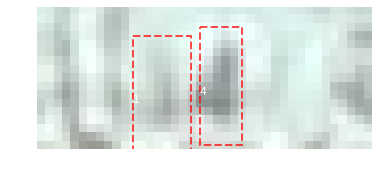

In [194]:
X, y = traindata[np.random.randint(len(traindata))]

## Draft code to extract bboxes
## inspiration: https://github.com/matterport/Mask_RCNN/blob/master/mrcnn/visualize.py

N = len(y['label'])
labels = []
boxes = []

for jj in range(N):
    labels.append(y['label'][jj])
    y1 = y['top'][jj]
    y2 = y1+y['height'][jj]
    x1 = y['left'][jj]
    x2 = x1 + y['width'][jj]
    
    boxes.append((y1,x1,y2,x2))
    

_, ax = plt.subplots(1)
plt.axis('off')
plt.imshow(X)
show_bbox = True
captions = True

for i in range(N):
    y1, x1, y2, x2 = boxes[i]
    # Show bbox
    if show_bbox:
        p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                            alpha=0.7, linestyle="dashed",
                            edgecolor='red', facecolor='none')
        ax.add_patch(p)
        
    # Show Label
    if captions:
        caption = labels[i]
        ax.text(x1, y1 + 8, caption,
            color='w', size=11, backgroundcolor="none")

    else:
        pass

In [94]:
# Add example of at least one transform
# use imgaug